In [1]:
import textblob
from textblob import TextBlob
string="Today is a good day."
blob=TextBlob(string)
blob_sent=blob.sentiment

In [2]:
blob_sent

Sentiment(polarity=0.7, subjectivity=0.6000000000000001)

(-0.5, 399.5, 199.5, -0.5)

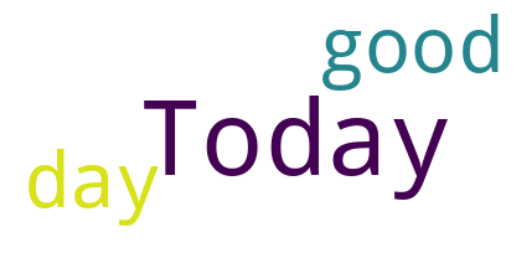

In [30]:
import wordcloud
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

my_stopwords=set(STOPWORDS)
my_stopwords.update(['the','a','an'])
my_cloud=WordCloud(background_color='white', stopwords=my_stopwords).generate(string)
plt.imshow(my_cloud,interpolation='bilinear')
plt.axis('off')
plt.show()

In [29]:
import sklearn
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, ENGLISH_STOP_WORDS
import pandas as pd

my_stopwords=ENGLISH_STOP_WORDS.union(['the'])
vect=CountVectorizer(token_pattern=r'\b[a-z]+\b',input='content', stop_words=my_stopwords) 
string_vect=vect.fit_transform([string])
pd.DataFrame(string_vect.toarray(), columns=vect.get_feature_names_out())

,day,good,today
0,1,1,1


In [39]:
import nltk 
from nltk import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer
string_tokens=word_tokenize(string)

porter=PorterStemmer()
snowball=SnowballStemmer("dutch")
WNlemmatizer=WordNetLemmatizer()
print([porter.stem(token) for token in string_tokens])
print(snowball.stem('beginnen'))
print(WNlemmatizer.lemmatize('wonderful', pos='a')) #'a' - adjective, 'n' - noun

['today', 'is', 'a', 'good', 'day', '.']
beginn
wonderful


In [25]:
from langdetect import detect_langs
foreign="Este libro ha sido uno de los mejors libros que he leido"
detect_langs(foreign)

[es:0.9999943617637173]

In [44]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()
sid.polarity_scores(string)

{'neg': 0.0, 'neu': 0.508, 'pos': 0.492, 'compound': 0.4404}

In [ ]:
import matplotlib as mpl
from mpl.toolkits.basemap import Basemap
m=Basemap(projection='merc',llcrnrlat=-35.62, llcrnrlon=-17.29, urcrnrlat=37.73, urcrnrlon=51.39)
m.fillcontinents(color='white',zorder=0)
m.drawcoastlines(color='gray')
m.drawcountries(color='gray')

m.scatter(<lons>,<lats>, latlon=True, c=<column>, cmap=<colormap>, alpha=0.7)